# PEFT

Сегодня LLM становятся незаменимым инструментом как для полноценного решения продуктовых задач, так и на промежуточных этапах, например, генерация разметки или создание синтетических датасетов. Обучение и дообучение таких моделей может быть ресурсозатратным, поэтому на зачастую полезно использовать Parameter-Efficient Fine-Tuning, PEFT.

PEFT позволяет адаптировать крупные языковые модели под конкретные задачи, внося минимальные изменения в архитектуру и обучаясь на сравнительно небольшом объёме данных. Ключевые методы – такие как адаптеры, LoRA или DoRA – демонстрируют высокую эффективность, позволяя достичь конкурентоспособной точности при низких затратах на вычислительные мощности.

Представьте, что ваша задача – определить тональность твитов. Твиты – короткие, насыщенные эмоциями и часто саркастичные сообщения, где традиционные модели могут давать сбои из-за неформального стиля и ограниченного контекста. Используя PEFT, вы можете донастроить LLM под особенности твиттер-лексикона, адаптируя модель на небольшом, но репрезентативном наборе данных.

## Импортируем зависимости

In [1]:
%pip install --quiet datasets bitsandbytes trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import gc
import os
import random
import re
import inspect
from functools import partial

import numpy as np
import torch
import torch.nn as nn
from datasets import load_dataset
from huggingface_hub import HfApi, interpreter_login
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments
from trl import SFTTrainer

In [3]:
interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Enter your token (input will not be visible): ··········
Add token as git credential? (Y/n) y


In [4]:
# Подготовим репозиторий для будущей модели и токенизатора
username = HfApi().whoami()["name"]
REPO_NAME = f"{username}/llm-course-hw3"  # Или как вам хочется

SEED = 42

print(f"Homework repository: '{REPO_NAME}'")

Homework repository: 'xinyuema/llm-course-hw3'


In [5]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


# Этой функцией будут помечены все места, которые необходимо дозаполнить
# Это могут быть как целые функции, так и отдельные части внутри них
# Всегда можно воспользоваться интроспекцией и найти места использования этой функции :)
def todo():
    stack = inspect.stack()
    caller_frame = stack[1]
    function_name = caller_frame.function
    line_number = caller_frame.lineno
    raise NotImplementedError(f"TODO at {function_name}, line {line_number}")


if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

set_seed(SEED)
print(f"{DEVICE=}")

DEVICE='cuda'


В качестве базовой модели возьмем [`Lite-Oute-1-300M-Instruct`](https://huggingface.co/OuteAI/Lite-Oute-1-300M-Instruct).
Она использует за основу Mistral и насчитывает около 300 млн параметров, размер контекста до 4096 токенов.

Вы можете использовать любую другую модель, однако обратите внимание, что используете на `Instruct` версию.

In [6]:
MODEL_NAME = "OuteAI/Lite-Oute-1-300M-Instruct"

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model = model.to(DEVICE)

os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/620 [00:00<?, ?B/s]

## Подготовка данных [2 балла]

Думаю, вы уже задумались над тем, что качество датасета для модели такого размера будет заметно влиять на перфоманс модели после обучения. Это действительно так, более того есть интересное исследование и на больших моделях: [LIMA: Less Is More for Alignment](https://arxiv.org/abs/2305.11206) показывает, что даже большие модели (например, Llama 65B) можно успешно обучить на небольшом, но исключительно качественном наборе данных.

Для нашей задачи воспользуемся стандартным датасетом классификации твиттов по тональности: [`cardiffnlp/tweet_eval`](https://huggingface.co/datasets/cardiffnlp/tweet_eval).

In [7]:
dataset = load_dataset("cardiffnlp/tweet_eval", "sentiment")

IDX2NAME = {0: "negative", 1: "neutral", 2: "positive"}


def add_str_label(example):
    example["str_label"] = IDX2NAME[example["label"]]
    return example


for split, data in dataset.items():
    dataset[split] = data.map(add_str_label)

for i in range(5):
    for k, v in dataset["train"][i].items():
        print(f"{k}: {v}")
    print("=" * 10)

README.md:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

text: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
label: 2
str_label: positive
text: "Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"
label: 1
str_label: neutral
text: Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.
label: 1
str_label: neutral
text: Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays
label: 1
str_label: neutral
text: @user Alciato: Bee will invest 150 million in January, another 200 in the Summer and plans to bring Messi by 2017"
label: 2
str_label: positive


Для подготовки датасета необходими

1. Задать системный промпт, в нем полезно описать задачу, а также определить формат генерации. В нашем случае это одно слово – название класса.
2. Задать пользовательский промпт, в котором будет находиться текст на классификацию.
3. Применить `chat_template` с помощью метода `tokenizer.apply_chat_template`, добавить начало генерации ассистента.
4. Токенизировать датасет.

In [8]:
SYSTEM_PROMPT = "You are a tweet sentiment classifier. " \
"For each tweet input, analyze its sentiment and output " \
"exactly one word: \"negative\", \"neutral\", or \"positive\". " \
"Do not include any extra text."
# SYSTEM_PROMPT = "For each tweet input, please analyze the sentiment of the following tweet and answer " \
# ": \"negative\", \"neutral\", or \"positive\". "
print(f"{SYSTEM_PROMPT=}")


def process_example(example, *, tokenizer, system_prompt=SYSTEM_PROMPT):
    """Processes a single example by constructing a chat-based prompt and tokenizing it.

    Process:
        1. Constructs a conversation comprising three roles:
            - "system": Provides instructions for classifying the sentiment.
            - "user": Presents the input message.
            - "assistant": Contains the expected sentiment answer.
        2. Applies the chat template to generate the full prompt.

    Parameters:
        example (dict): A dictionary with keys:
            - 'text': The message to be classified.
            - 'str_label': The expected sentiment label.
        system_prompt (str): System prompt to use

    Returns:
        dict: Extended dictionary containing conversational prompts:
            - 'prompt': Input task
            - 'full_prompt': Full conversation including task label
    """
    # todo()
    prompt = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": example["text"]}
    ]
    full_prompt = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": example["text"]},
        {"role": "assistant", "content": example["str_label"]}
    ]

    prompt = tokenizer.apply_chat_template(prompt, tokenize=False, add_generation_prompt=True)
    full_prompt = tokenizer.apply_chat_template(full_prompt, tokenize=False)

    return {
        "prompt": prompt,
        "full_prompt": full_prompt
    }

SYSTEM_PROMPT='You are a tweet sentiment classifier. For each tweet input, analyze its sentiment and output exactly one word: "negative", "neutral", or "positive". Do not include any extra text.'


In [9]:
for split, data in dataset.items():
    dataset[split] = data.map(process_example, fn_kwargs={"tokenizer": tokenizer})

for i in range(2):
    for k, v in dataset["train"][i].items():
        print(f"{k}: {v}")
    print("=" * 10)

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

text: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
label: 2
str_label: positive
prompt: <|im_start|>system
You are a tweet sentiment classifier. For each tweet input, analyze its sentiment and output exactly one word: "negative", "neutral", or "positive". Do not include any extra text.<|im_end|>
<|im_start|>user
"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"<|im_end|>
<|im_start|>assistant

full_prompt: <|im_start|>system
You are a tweet sentiment classifier. For each tweet input, analyze its sentiment and output exactly one word: "negative", "neutral", or "positive". Do not include any extra text.<|im_end|>
<|im_start|>user
"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"<|im_end|>
<|im_start|>assistant
positive<|im_end|>

text: "Ben Smith / Smith (concussion) remains o

In [10]:
def tokenization(example, *, tokenizer, max_length=256):
    """Tokenize both prompt and full prompt and
    save result in `input_ids` and `full_input_ids` keys along with original keys
    """
    # todo()
    input_ids = tokenizer(example["prompt"], max_length=max_length, truncation=True)["input_ids"]
    full_input_ids = tokenizer(example["full_prompt"], max_length=max_length, truncation=True)["input_ids"]
    return {
        "input_ids": input_ids,
        "full_input_ids": full_input_ids
    }


for split, data in dataset.items():
    dataset[split] = data.map(tokenization, batched=True, fn_kwargs={"tokenizer": tokenizer})

for i in range(2):
    for k, v in dataset["train"][i].items():
        print(f"{k}: {v}")
    print("=" * 10)

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

text: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
label: 2
str_label: positive
prompt: <|im_start|>system
You are a tweet sentiment classifier. For each tweet input, analyze its sentiment and output exactly one word: "negative", "neutral", or "positive". Do not include any extra text.<|im_end|>
<|im_start|>user
"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"<|im_end|>
<|im_start|>assistant

full_prompt: <|im_start|>system
You are a tweet sentiment classifier. For each tweet input, analyze its sentiment and output exactly one word: "negative", "neutral", or "positive". Do not include any extra text.<|im_end|>
<|im_start|>user
"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"<|im_end|>
<|im_start|>assistant
positive<|im_end|>

input_ids: [1, 32001, 1587, 13, 1976, 460, 264,

Попробуем решить задачу исходной моделью!

In [11]:
def generate_class(model, tokenizer, input_ids):
    output_ids = model.generate(input_ids, max_new_tokens=16)
    generated_text = tokenizer.decode(output_ids[0][len(input_ids[0]) :], skip_special_tokens=True)
    return generated_text


for i in range(5):
    input_ids = torch.tensor([dataset["train"][i]["input_ids"]], device=DEVICE)
    generated_text = generate_class(model, tokenizer, input_ids)
    print(dataset["train"][i]["text"])
    print(dataset["train"][i]["str_label"])
    print(generated_text)
    print("=" * 10)

"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
positive
The tweet "QT @user In the original draft of the 7
"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"
neutral
The tweet "Ben Smith / Smith (concussion) remains out of the
Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.
neutral
The stream last night was a bit of a disappointment. I had a great time
Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays
neutral
The tweet "Negative" is a positive sentiment. 
@user Alciato: Bee will invest 150 million in January, another 200 in the Summer and plans to bring Messi by 2017"
positive
The tweet "Alciato: Bee will invest 150


Если вам повезло, после слова `assistant` вы увидите определение сентиментальности входящего текста. Однако, скорее всего, модель не обучена возвращать исключительно название тональности, поэтому необходим постпроцессинг ответа. Рассмотрим самый простой способ его реализации.

## Bonus: постпроцессинг [1 балл]

Ниже приведена базовая реализация функции для выделения сентиментальности текста. Однако текущая реализация имеет несколько недостатков: она может не учитывать нестандартное форматирование ответа модели, дополнительные символы или ошибки пунктуации. У вас есть возможность улучшить эту функцию, обосновать выявленные ограничения и предложить более продвинутую версию, способную корректно обрабатывать различные варианты вывода модели.

Если вы не хотите в этом копаться, то просто пропустите задание

In [12]:
def postprocess_sentiment(output_text: str) -> str:
    """
    Extracts the sentiment classification ("positive" or "negative") from the model's output text.

    Process:
        1. Splits the output at the first occurrence of the keyword "assistant" and processes the text after it.
        2. Uses a regular expression to search for the first occurrence of the words "positive" or "negative" (ignoring case).
        3. Returns the found sentiment in lowercase. If no match is found, returns an empty string.

    Parameters:
        output_text (str): The complete text output from the model, including conversation headers.

    Returns:
        str: The sentiment classification or empty string
    """


    segments = re.split(rf'\bassistant\b[:\s]*', output_text, flags=re.IGNORECASE)

    text_to_process = segments[-1] if len(segments) > 1 else output_text

    cleaned_text = re.sub(rf'[^\w\s]', ' ', text_to_process)

    match = re.search(rf"\b({'|'.join(IDX2NAME.values())})\b", cleaned_text, flags=re.IGNORECASE)
    return match.group(1).lower() if match else ""

In [13]:
postprocess_sentiment("This text is neutral, not positive or negative")

'neutral'

## Оценка модели

Давайте оценим качество нашей модели. Для этого напишем функцию `eval`, которая принимает модель и датасет, генерирует для каждого примера предсказание и вычисляет точность классификации, сравнивая полученные результаты с истинными метками. Построим матрицу ошибок и посчитаем f1 для каждого класса.

In [17]:
def pad(tensors: list[torch.Tensor], padding_value: int = 0, padding_side: str = "left") -> torch.Tensor:
    """Pads a list of tensors to the same size along their leading dimension.

    Args:
        tensors (list[torch.Tensor]): A list of tensors to be padded.
            All tensors in the list should be of the same type and device.
        padding_value (int, default=0): The value used to pad the tensors.
        padding_side (str, default="right"): Specifies which side of the tensor to apply padding: either 'left' or 'right'.

    Returns:
        torch.Tensor: A tensor containing all the padded tensors, [N; max_length]
            where N is the number of tensors and `max_length` is the shape of the largest tensor.
    """
    max_length = max(tensor.size(0) for tensor in tensors)
    trailing_dims = tensors[0].size()[1:]
    padded_shape = (len(tensors), max_length) + trailing_dims
    padding_tensor = torch.full(padded_shape, padding_value, device=tensors[0].device)

    for i, tensor in enumerate(tensors):
        length = len(tensor)
        if padding_side == "right":
            padding_tensor[i, :length, ...] = tensor
        elif padding_side == "left":
            padding_tensor[i, -length:, ...] = tensor

    return padding_tensor

In [18]:
@torch.inference_mode
def eval(model, dataset, tokenizer, show_conf_m=True, batch_size=100):
    """Evaluates the given model on the provided dataset.

    Parameters:
        model: The language model used for generating sentiment predictions.
        dataset: An iterable collection of examples, where each example is a dict with keys:
            - "input_ids": The input text message.
            - "str_label": The ground truth sentiment label (e.g., "positive" or "negative").

    Returns:
        float: The macro f1 score
    """
    name2idx = {v: k for k, v in IDX2NAME.items()}
    name2idx[""] = len(name2idx)
    ground_truth = []
    predicted = []

    for examples in tqdm(dataset.batch(batch_size)):
        input_ids = pad(list(map(torch.tensor, examples["input_ids"])), padding_value=tokenizer.pad_token_id).to(DEVICE)
        attention_mask = pad(list(map(lambda it: torch.ones(len(it)), examples["input_ids"])), padding_value=0).to(
            DEVICE
        )
        output_ids = model.generate(input_ids, attention_mask=attention_mask, max_new_tokens=16)
        shrinked_ids = output_ids[:, input_ids.shape[1] :]
        texts = tokenizer.batch_decode(shrinked_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

        for i in range(len(examples["str_label"])):
            predicted_sentiment = postprocess_sentiment(texts[i])
            ground_truth.append(name2idx[examples["str_label"][i]])
            predicted.append(name2idx[predicted_sentiment])

    if show_conf_m:
        conf_m = confusion_matrix(ground_truth, predicted, labels=list(name2idx.values()))
        disp = ConfusionMatrixDisplay(conf_m, display_labels=list(name2idx.keys()))
        disp.plot(cmap = 'Blues')

    f1 = f1_score(ground_truth, predicted, labels=list(name2idx.values()), average="macro", zero_division=0.0)
    return f1

Batching examples:   0%|          | 0/12284 [00:00<?, ? examples/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Initial Macro F1: 0.06


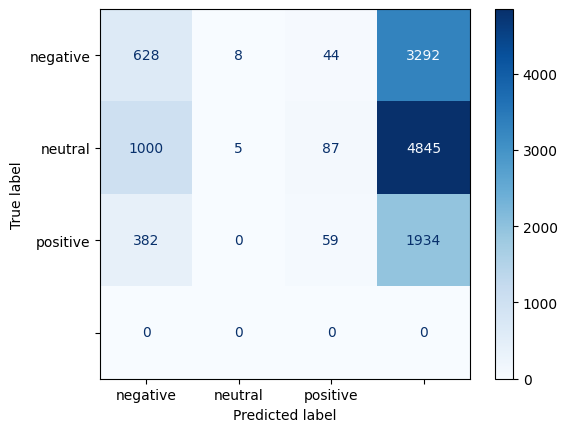

In [19]:
initial_f1 = eval(model, dataset["test"], tokenizer)
print(f"Initial Macro F1: {initial_f1:.2f}")

# LoRA: [Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685)

В традиционном fine-tuning больших языковых моделей требуется обновление огромного числа параметров, что приводит к высоким вычислительным затратам и потреблению памяти. Метод LoRA решает эту проблему, вводя низкоранговые обновления весов.

Пусть $(W_0 \in \mathbb{R}^{d \times k})$ - исходная матрица весов модели. При адаптации модели предполагается, что обновление весов можно аппроксимировать матрицей низкого ранга:
$$
\Delta W = BA, \quad B \in \mathbb{R}^{d \times r}, \quad A \in \mathbb{R}^{r \times k},
$$
где $r \ll \min(d, k)$.

Обновлённая матрица весов записывается как:
$$
W = W_0 + \Delta W = W_0 + B A.
$$

Основная идея заключается в том, чтобы заморозить исходные параметры $W_0$ и обучать только матрицы $A$ и $B$. Это существенно уменьшает число обучаемых параметров, так как их суммарное количество равно $r \times (d+k)$ по сравнению с $d \times k$ для полной матрицы $W$.

Матрицу $A$ рекомендуется инициализировать нормальным распределением $N(0, \frac{1}{\sqrt{r}})$, а матрицу $B$ нулями. Также не забывайте про скейлинг $\Delta Wx$ на $\frac{\alpha}{r}$, где $\alpha$ гипер-параметр. Во время обучения его можно зафиксировать $\alpha=16$.

## Адаптиация модели с LoRA слоями [4 балла]

В этом задачнии вам потребуется:
1. Дописать класс `LoRALayer` который заменит слои модели
2. Дописать функцию рекурсивного обхода модели, чтобы применить к ней `LinearWithLoRA`
3. Обновить модель

In [20]:
class LoRALayer(nn.Module):
    """Implements a low-rank adaptation layer for a linear transformation.
    This layer introduces a trainable low-rank update to the input tensor.

    The forward computation is defined as:
        output = alpha * (x @ A @ B)

    Attributes:
        B (nn.Parameter): A weight matrix of shape (in_dim, rank), initialized to zeros.
        A (nn.Parameter): A weight matrix of shape (rank, out_dim), initialized with random values
                            scaled by 1/sqrt(rank).
        alpha (float): A scaling factor for the low-rank update.
    """

    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        scale = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = nn.Parameter(torch.randn(in_dim, rank) * scale)
        self.B = nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        return self.alpha * (x @ self.A @ self.B)


class LinearWithLoRA(nn.Module):
    """Combines a standard linear layer with a LoRA (Low-Rank Adaptation) layer.
    The forward pass returns the sum of the output of the linear layer and the low-rank update.

    Attributes:
        linear (nn.Module): The original linear layer.
        lora (LoRALayer): The low-rank adaptation layer configured with matching input and output dimensions.
    """

    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(linear.in_features, linear.out_features, rank, alpha)

    def forward(self, x):
        return self.linear(x) + self.lora(x)

In [21]:
def apply_peft_to_module(model, adapter_class, r, alpha, target_submodules):
    """Recursively applies a parameter-efficient fine-tuning (PEFT) adapter to target submodules within a model.

    This function traverses the model's children recursively. For each submodule whose name contains any
    of the strings specified in 'target_submodules', it wraps the submodule using the provided adapter class.

    Args:
        model (nn.Module): The neural network model to modify.
        adapter_class (nn.Module): The adapter class (e.g., LoRALayer or LinearWithLoRA) used to wrap target submodules.
        r (int): The rank parameter for the adapter.
        alpha (float): The scaling factor for the low-rank update.
        target_submodules (list of str): A list of substrings to match against submodule names for applying the adapter.

    Returns:
        None. The function updates the model in-place.
    """
    def _apply_peft_to_module(module, target_submodules, current_name=""):
        for name, child in module.named_children():
            layer_name = f"{current_name}.{name}" if current_name else name
            if name in target_submodules:
                adapter_layer = adapter_class(child, r, alpha).to(model.device)
                setattr(module, name, adapter_layer)
            else:
                _apply_peft_to_module(child, target_submodules, layer_name)
    _apply_peft_to_module(model, target_submodules)

### Применим наш LoRA adapter к нашей модели

Обычно для дешевого обучения достаточно применить LoRA к слоям для ключей `k_proj` и значений `v_proj`. Однако, если вы уверены в своих действиях, то не воспрещается обучать и другие слои с помощью LoRA :)

In [22]:
# Примените peft к модели
apply_peft_to_module(model, LinearWithLoRA, r=8, alpha=16, target_submodules=["k_proj", "v_proj"])

In [23]:
# Заморозьте не нужные слои


def freeze_layers(model, patterns):
    for name, param in model.named_parameters():
        # todo()
        for pattern in patterns:
            if pattern not in name:
                param.requires_grad = False

    total_params, trainable_params = 0, 0
    for name, param in model.named_parameters():
        print(f"{name}: {param.requires_grad}")
        total_params += np.prod(param.shape)
        if param.requires_grad:
            trainable_params += np.prod(param.shape)
    print(f"Train {trainable_params}/{total_params} ({trainable_params / total_params * 100:.2f}%) parameters")

    return model


model = freeze_layers(model, ["lora"])

model.embed_tokens.weight: False
model.layers.0.self_attn.q_proj.weight: False
model.layers.0.self_attn.k_proj.linear.weight: False
model.layers.0.self_attn.k_proj.lora.A: True
model.layers.0.self_attn.k_proj.lora.B: True
model.layers.0.self_attn.v_proj.linear.weight: False
model.layers.0.self_attn.v_proj.lora.A: True
model.layers.0.self_attn.v_proj.lora.B: True
model.layers.0.self_attn.o_proj.weight: False
model.layers.0.mlp.gate_proj.weight: False
model.layers.0.mlp.up_proj.weight: False
model.layers.0.mlp.down_proj.weight: False
model.layers.0.input_layernorm.weight: False
model.layers.0.post_attention_layernorm.weight: False
model.layers.1.self_attn.q_proj.weight: False
model.layers.1.self_attn.k_proj.linear.weight: False
model.layers.1.self_attn.k_proj.lora.A: True
model.layers.1.self_attn.k_proj.lora.B: True
model.layers.1.self_attn.v_proj.linear.weight: False
model.layers.1.self_attn.v_proj.lora.A: True
model.layers.1.self_attn.v_proj.lora.B: True
model.layers.1.self_attn.o_proj

## Обучение [2 балла]

*Напутствие:*
Пришло время приступить к обучению модели. После реализации train loop вы заслужите перерыв на 30+ минут – отличный повод с гордостью заявить, что вы заняты обучением модели. Однако длительность отдыха остаётся на ваше усмотрение. Мы рекомендуем ограничиться 2–3 эпохами файнтюна, чтобы избежать излишних вычислительных затрат и переобучения модели.

Обратите внимание, что вам предстоит реализовать классический train loop на PyTorch. Здесь у вас достаточно свободы для выбора гиперпараметров (`batch_size`, `lr`, `num_epochs`). Вы можете использовать дополнительные гиперпараметры на свое усмотрение, например, для оптимизатора.

In [24]:
def pad_collate_fn(batch: list[dict[str, torch.Tensor]], pad_token_id: int) -> dict[str, torch.Tensor]:
    """
    Collates and pads a batch of tokenized examples for model input.

    This function processes a batch of examples, each containing:
      - "input_ids": Token IDs for the prompt.
      - "full_input_ids": Token IDs for the combined prompt and response.

    The function performs the following steps:
      1. Converts "input_ids" and "full_input_ids" into tensors.
      2. Pads all sequences to the same maximum length using left-side padding.
      3. Constructs the labels tensor by masking the prompt portion with -100
         (indicating no loss calculation for these tokens) and retaining the
         response tokens.
      4. Ensures that the input sequences and attention masks are aligned with
         the labels in length by appending padding as necessary.

    Args:
        batch (list[dict[str, torch.Tensor]]): A list of dictionaries, each containing:
            - "input_ids": Tensor of token IDs for the prompt.
            - "full_input_ids": Tensor of token IDs for the full sequence (prompt + response).
        pad_token_id (int): The token ID used for padding sequences.

    Returns:
        dict[str, torch.Tensor]: A dictionary with the following keys:
            - "input_ids": Padded token IDs for the model input (prompt + assistant padding).
            - "attention_mask": Corresponding attention mask (1s for actual tokens, 0s for padding).
            - "labels": Labels tensor with the prompt portion masked (-100) and response portion retained.
    """

    prompt_input_ids = [torch.tensor(sample["input_ids"]) for sample in batch]
    prompt_attention_masks = [torch.ones_like(tensor) for tensor in prompt_input_ids]
    full_input_ids = [torch.tensor(sample["full_input_ids"]) for sample in batch]
    padded_prompt_ids = pad(prompt_input_ids, padding_value=pad_token_id, padding_side="left")
    padded_prompt_attn = pad(prompt_attention_masks, padding_value=0, padding_side="left")
    padded_full_ids = pad(full_input_ids, padding_value=pad_token_id, padding_side="left")
    labels_mask = torch.full_like(padded_prompt_ids, -100)
    response_part = padded_full_ids[:, labels_mask.size(1):]
    labels = torch.cat((labels_mask, response_part), dim=1)
    assistant_padding_length = labels.size(1) - padded_prompt_ids.size(1)
    assistant_ids = torch.full((labels.size(0), assistant_padding_length), pad_token_id)
    assistant_mask = torch.full((labels.size(0), assistant_padding_length), 0)

    input_ids = torch.cat((padded_prompt_ids, assistant_ids), dim=1)
    attention_mask = torch.cat((padded_prompt_attn, assistant_mask), dim=1)

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels,
    }

In [25]:
dataloader = DataLoader(
    dataset["train"],
    batch_size=2,
    shuffle=True,
    collate_fn=partial(pad_collate_fn, pad_token_id=tokenizer.pad_token_id),
)
next(iter(dataloader))

{'input_ids': tensor([[32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
          32000, 32000,     1, 32001,  1587,    13,  1976,   460,   264,  9394,
            299, 21790,   875,  3591, 28723,  1263,  1430,  9394,   299,  2787,
          28725, 20765,   871, 21790,   304,  3825,  4668,   624,  1707, 28747,
            345, 23238,   548,   345, 23806,  1650,   548,   442,   345,  1065,
           2468,  2586,  2378,   459,  3024,   707,  4210,  2245, 28723, 32000,
          28705,    13, 32001,  2188,    13, 28737,   541, 28756, 28718, 28750,
          28734, 28740, 28774, 28707,  2444,   298,  1236,   456, 12165,  2737,
          13268,   684,  9262,  2125, 13915,  3539, 28716,   521,   295,  8884,
           4893,  4382, 32000, 28705,    13, 32001, 13892,    13, 32000, 32000,
          32000, 32000],
         [    1, 32001,  1587,    13,  1976,   460,   264,  9394,   299, 21790,
            875,  3591, 28723,  1263,  1430,  9394,   299,  2787, 28725, 20765,
  

In [26]:
def train_model(model, optimizer, train_dataloader, val_dataset, num_epochs):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for step, batch in enumerate(tqdm(train_dataloader)):
            batch = {k: (v.to(model.device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

            running_loss += loss.item()
            if step % 50 == 0 and step > 0:
                avg_loss = running_loss / 50
                print(f"Epoch {epoch + 1}, Step {step} | Avg Loss: {avg_loss:.4f}")
                running_loss = 0.0

        val_f1 = eval(model, val_dataset, tokenizer, show_conf_m=False)
        print(f"Epoch {epoch + 1} | Validation F1: {val_f1}")
    return model

In [27]:
BATCH_SIZE = 16
LEARNING_RATE = 5e-6
NUM_EPOCHS = 2

train_dataloader = DataLoader(
    dataset["train"],
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=partial(pad_collate_fn, pad_token_id=tokenizer.pad_token_id),
)

optimizer = torch.optim.AdamW([p for n, p in model.named_parameters() if "lora" in n], lr=LEARNING_RATE)

In [28]:
model = train_model(model, optimizer, train_dataloader, dataset["validation"], NUM_EPOCHS)

  0%|          | 0/2851 [00:00<?, ?it/s]

Epoch 1, Step 50 | Avg Loss: 3.1821
Epoch 1, Step 100 | Avg Loss: 1.4261
Epoch 1, Step 150 | Avg Loss: 1.0012
Epoch 1, Step 200 | Avg Loss: 1.8535
Epoch 1, Step 250 | Avg Loss: 1.2268
Epoch 1, Step 300 | Avg Loss: 1.0455
Epoch 1, Step 350 | Avg Loss: 1.5324
Epoch 1, Step 400 | Avg Loss: 1.1826
Epoch 1, Step 450 | Avg Loss: 1.6056
Epoch 1, Step 500 | Avg Loss: 1.1373
Epoch 1, Step 550 | Avg Loss: 1.2227
Epoch 1, Step 600 | Avg Loss: 1.5938
Epoch 1, Step 650 | Avg Loss: 1.1338
Epoch 1, Step 700 | Avg Loss: 1.0823
Epoch 1, Step 750 | Avg Loss: 0.7022
Epoch 1, Step 800 | Avg Loss: 1.1745
Epoch 1, Step 850 | Avg Loss: 0.9584
Epoch 1, Step 900 | Avg Loss: 0.9541
Epoch 1, Step 950 | Avg Loss: 0.6584
Epoch 1, Step 1000 | Avg Loss: 1.2275
Epoch 1, Step 1050 | Avg Loss: 0.8136
Epoch 1, Step 1100 | Avg Loss: 0.8721
Epoch 1, Step 1150 | Avg Loss: 1.1538
Epoch 1, Step 1200 | Avg Loss: 1.3121
Epoch 1, Step 1250 | Avg Loss: 1.0309
Epoch 1, Step 1300 | Avg Loss: 1.3046
Epoch 1, Step 1350 | Avg Loss: 0

Batching examples:   0%|          | 0/2000 [00:00<?, ? examples/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 | Validation F1: 0.4003477424021719


  0%|          | 0/2851 [00:00<?, ?it/s]

Epoch 2, Step 50 | Avg Loss: 0.9039
Epoch 2, Step 100 | Avg Loss: 1.0934
Epoch 2, Step 150 | Avg Loss: 0.7087
Epoch 2, Step 200 | Avg Loss: 0.9394
Epoch 2, Step 250 | Avg Loss: 1.0572
Epoch 2, Step 300 | Avg Loss: 1.0256
Epoch 2, Step 350 | Avg Loss: 0.7297
Epoch 2, Step 400 | Avg Loss: 0.9260
Epoch 2, Step 450 | Avg Loss: 1.1017
Epoch 2, Step 500 | Avg Loss: 0.6733
Epoch 2, Step 550 | Avg Loss: 1.0662
Epoch 2, Step 600 | Avg Loss: 0.9642
Epoch 2, Step 650 | Avg Loss: 0.6764
Epoch 2, Step 700 | Avg Loss: 0.9363
Epoch 2, Step 750 | Avg Loss: 0.7254
Epoch 2, Step 800 | Avg Loss: 0.9532
Epoch 2, Step 850 | Avg Loss: 0.7013
Epoch 2, Step 900 | Avg Loss: 0.8309
Epoch 2, Step 950 | Avg Loss: 0.7895
Epoch 2, Step 1000 | Avg Loss: 0.9411
Epoch 2, Step 1050 | Avg Loss: 0.7865
Epoch 2, Step 1100 | Avg Loss: 0.8936
Epoch 2, Step 1150 | Avg Loss: 0.8828
Epoch 2, Step 1200 | Avg Loss: 0.7710
Epoch 2, Step 1250 | Avg Loss: 0.9104
Epoch 2, Step 1300 | Avg Loss: 0.7657
Epoch 2, Step 1350 | Avg Loss: 1

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 | Validation F1: 0.41129731053104185


In [29]:
for i in range(5):
    input_ids = torch.tensor([dataset["train"][i]["input_ids"]], device=DEVICE)
    generated_text = generate_class(model, tokenizer, input_ids)
    print(dataset["train"][i]["text"])
    print(dataset["train"][i]["str_label"])
    print(generated_text)
    print("=" * 10)

"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
positive
positive 

"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"
neutral
neutral 
ralph
neutral 
ral
Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.
neutral
neutral 
ralitive
neutral
ralitive
Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays
neutral
neutral 
ralitive
ralitive
ralitive
@user Alciato: Bee will invest 150 million in January, another 200 in the Summer and plans to bring Messi by 2017"
positive
neutral 
ralitive
ralitive
ralitive


## Оценим результаты

Теперь увидим, как повлиял наш файнтюнинг

  0%|          | 0/123 [00:00<?, ?it/s]

After LoRA Macro F1: 0.40


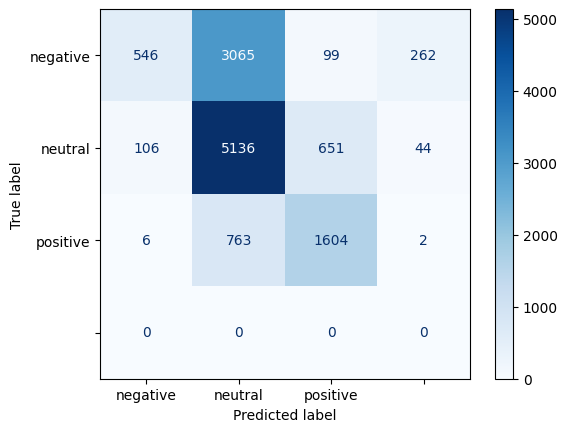

In [30]:
after_lora_f1 = eval(model, dataset["test"], tokenizer)
print(f"After LoRA Macro F1: {after_lora_f1:.2f}")

In [31]:
# Загружаем все на хаб
model.push_to_hub(f"{REPO_NAME}-lora", private=True)
tokenizer.push_to_hub(f"{REPO_NAME}-lora", private=True)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/xinyuema/llm-course-hw3-lora/commit/dc8a5cc4d2ee5e6132318347e2390e6c8bd803cb', commit_message='Upload tokenizer', commit_description='', oid='dc8a5cc4d2ee5e6132318347e2390e6c8bd803cb', pr_url=None, repo_url=RepoUrl('https://huggingface.co/xinyuema/llm-course-hw3-lora', endpoint='https://huggingface.co', repo_type='model', repo_id='xinyuema/llm-course-hw3-lora'), pr_revision=None, pr_num=None)

In [32]:
# Очистим память
gc.collect()
torch.cuda.empty_cache()

## DoRA: [Weight-Decomposed Low-Rank Adaptation](https://arxiv.org/abs/2402.09353)

В отличие от метода LoRA, где обновление весов модели представлено в виде низкорангового произведения, метод DoRA вводит дополнительную степень гибкости за счёт применения диагональной матрицы для весового масштабирования.

Пусть $W_0 \in \mathbb{R}^{d \times k}$ - исходная матрица весов. В DoRA обновление весов определяется следующим образом:
$$
W = m \frac{W_0 + BA}{\|W_0 + BA \|}
$$

Где $BA$ соответствует использованию LoRA, а $m \in \mathbb{R}^{k}$ обучаемый вектор.

## Обучение модели с помощью DoRA [8 баллов]

В этом задании вам потребуется:
1. Написать с нуля класс `LinearWithDoRA` который использует написанный ранее `LoRALayer` класс
2. Применить его к модели
3. Обучить модель

In [33]:
class LinearWithDoRA(nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        # todo()
        self.linear = linear
        self.lora = LoRALayer(linear.in_features, linear.out_features, rank, alpha)
        self.lora_magnitude = nn.Parameter(
            self.linear.weight.norm(p=2, dim=0, keepdim=True)
        )

    def forward(self, x):
        # todo()
        weight = self.linear.weight + self.lora.alpha * (self.lora.A @ self.lora.B).T
        direction = weight / weight.norm(p=2, dim=0, keepdim=True)
        dora_weight = self.lora_magnitude * direction
        return torch.nn.functional.linear(x, dora_weight, self.linear.bias)

Сбрасываем модель и применяем наш DoRA адаптер

In [34]:
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model = model.to(DEVICE)

apply_peft_to_module(model, LinearWithDoRA, r=8, alpha=16, target_submodules=["k_proj", "v_proj"])

model = freeze_layers(model, ["lora"])

model.embed_tokens.weight: False
model.layers.0.self_attn.q_proj.weight: False
model.layers.0.self_attn.k_proj.lora_magnitude: True
model.layers.0.self_attn.k_proj.linear.weight: False
model.layers.0.self_attn.k_proj.lora.A: True
model.layers.0.self_attn.k_proj.lora.B: True
model.layers.0.self_attn.v_proj.lora_magnitude: True
model.layers.0.self_attn.v_proj.linear.weight: False
model.layers.0.self_attn.v_proj.lora.A: True
model.layers.0.self_attn.v_proj.lora.B: True
model.layers.0.self_attn.o_proj.weight: False
model.layers.0.mlp.gate_proj.weight: False
model.layers.0.mlp.up_proj.weight: False
model.layers.0.mlp.down_proj.weight: False
model.layers.0.input_layernorm.weight: False
model.layers.0.post_attention_layernorm.weight: False
model.layers.1.self_attn.q_proj.weight: False
model.layers.1.self_attn.k_proj.lora_magnitude: True
model.layers.1.self_attn.k_proj.linear.weight: False
model.layers.1.self_attn.k_proj.lora.A: True
model.layers.1.self_attn.k_proj.lora.B: True
model.layers.1.

### Обучение

In [35]:
BATCH_SIZE = 16
LEARNING_RATE = 3e-5
NUM_EPOCHS = 1

train_dataloader = DataLoader(
    dataset["train"].take(10_000),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=partial(pad_collate_fn, pad_token_id=tokenizer.pad_token_id),
)

optimizer = torch.optim.AdamW(
    [p for n, p in model.named_parameters() if "lora" in n], lr=LEARNING_RATE, weight_decay=0.01
)

In [36]:
model = train_model(model, optimizer, train_dataloader, dataset["validation"], NUM_EPOCHS)

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1, Step 50 | Avg Loss: 1.7593
Epoch 1, Step 100 | Avg Loss: 1.3665
Epoch 1, Step 150 | Avg Loss: 1.1944
Epoch 1, Step 200 | Avg Loss: 0.7437
Epoch 1, Step 250 | Avg Loss: 1.4347
Epoch 1, Step 300 | Avg Loss: 0.8928
Epoch 1, Step 350 | Avg Loss: 1.1041
Epoch 1, Step 400 | Avg Loss: 0.9776
Epoch 1, Step 450 | Avg Loss: 0.8725
Epoch 1, Step 500 | Avg Loss: 0.9755
Epoch 1, Step 550 | Avg Loss: 0.8700
Epoch 1, Step 600 | Avg Loss: 0.7274


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 | Validation F1: 0.3635631897732481


In [37]:
for i in range(5):
    input_ids = torch.tensor([dataset["train"][i]["input_ids"]], device=DEVICE)
    generated_text = generate_class(model, tokenizer, input_ids)
    print(dataset["train"][i]["text"])
    print(dataset["train"][i]["str_label"])
    print(generated_text)
    print("=" * 10)

"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
positive
positive 
"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"
neutral
neutral 
ralphralphralphralphralph
Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.
neutral

positive 
ralitive
Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays
neutral
neutral 
ralicious
@user Alciato: Bee will invest 150 million in January, another 200 in the Summer and plans to bring Messi by 2017"
positive
neutral 
ralitive


  0%|          | 0/123 [00:00<?, ?it/s]

After DoRA Macro F1: 0.34


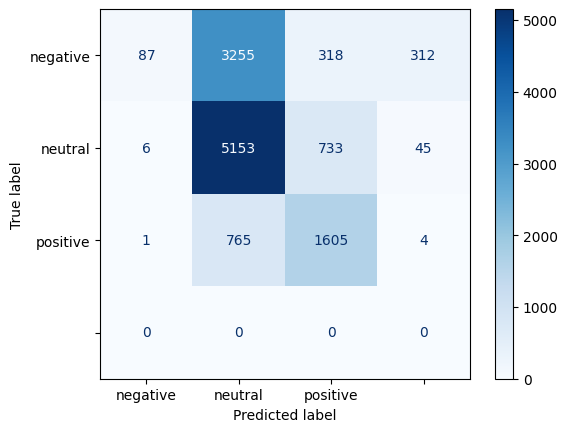

In [38]:
after_dora_f1 = eval(model, dataset["test"], tokenizer)
print(f"After DoRA Macro F1: {after_dora_f1:.2f}")

Для качественного обучения доры в этой задаче нужно постараться.
Будем считать, что если качество > 0.5, то задание с учетом правильности кода решено верно

In [39]:
# Загружаем все на хаб

model.push_to_hub(f"{REPO_NAME}-dora", private=True)
tokenizer.push_to_hub(f"{REPO_NAME}-dora", private=True)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/xinyuema/llm-course-hw3-dora/commit/3ab4e9ae67dbf50ad9ade3f12b913018fecd433b', commit_message='Upload tokenizer', commit_description='', oid='3ab4e9ae67dbf50ad9ade3f12b913018fecd433b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/xinyuema/llm-course-hw3-dora', endpoint='https://huggingface.co', repo_type='model', repo_id='xinyuema/llm-course-hw3-dora'), pr_revision=None, pr_num=None)

In [40]:
# Очистим память
gc.collect()
torch.cuda.empty_cache()

## Frameworks way [4 балла]

### QLoRA: [Efficient Finetuning of Quantized LLMs](https://arxiv.org/pdf/2305.14314)

Метод QLoRA направлен на эффективное дообучение предварительно обученных больших языковых моделей с использованием квантования весов. Основная идея заключается в том, что во время обратного распространения ошибки модель квантует исходные веса с точностью до 4 бит, что позволяет значительно сократить использование GPU памяти. Для обработки пиков памяти при этом применяются страничные оптимизаторы.

В результате, применение QLoRA часто приводит к экономии GPU памяти примерно на $\dfrac{1}{3}$, однако время обучения при этом может увеличиться почти на $\dfrac{1}{4}$ по сравнению с традиционными методами дообучения.

Такой компромисс между экономией памяти и увеличением времени обучения делает QLoRA привлекательным решением в сценариях, где ресурсы ограничены, а эффективность использования памяти критически важна.

Теперь с таким прекрасным инструментом как QLoRA можем рассмотреть более тяжелую модель аж 1.1B :)

Используйте документацию библиотек [HuggingFace Transformers](https://huggingface.co/docs/transformers/index) и [PEFT](https://huggingface.co/docs/peft/index).

1. Конфигурация квантизации (`BitsAndBytesConfig`): Подберите тип 4-битной квантизации (`bnb_4bit_quant_type`) и размерность подсчёта (`bnb_4bit_compute_dtype`)

2. Настройка LoRA-адаптеров (`LoraConfig`):
    - Подберите и обоснуйте значения следующих гиперпараметров:
        - `lora_alpha`
        - `lora_dropout`
        - `r`
    - Выберите модули модели, к которым следует применять LoRA-адаптеры (`target_modules`).

3. Настройка параметров обучения (`TrainingArguments`, `SFTTrainer`):
Используя документацию и подберите параметры:
    - `learning_rate`
    - `num_train_epochs`
    - `gradient_accumulation_steps`
    - `lr_scheduler_type`
    - `per_device_train_batch_size`
    - другие параметры по необходимости

4. Проведение обучения и анализ результатов:
    - Запустите обучение модели.
    - Оцените модель до и после обучения.
    - сохраните модель


In [41]:
LARGE_MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Заведем конфиг для квантизации
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4", # todo()
    bnb_4bit_compute_dtype=torch.bfloat16, # todo()
)

# Инициализация квантованной модели
model = AutoModelForCausalLM.from_pretrained(LARGE_MODEL_NAME, quantization_config=bnb_config)
model = model.to(DEVICE)

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [42]:
tokenizer = AutoTokenizer.from_pretrained(LARGE_MODEL_NAME)
# tokenizer.pad_token = "<PAD>"
tokenizer.padding_side = "left"

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

In [43]:
for split, data in dataset.items():
    dataset[split] = data.map(process_example, fn_kwargs={"tokenizer": tokenizer})
    dataset[split] = data.map(tokenization, batched=True, fn_kwargs={"tokenizer": tokenizer})

for i in range(2):
    for k, v in dataset["train"][i].items():
        print(f"{k}: {v}")
    print("=" * 10)

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

text: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
label: 2
str_label: positive
prompt: <|im_start|>system
You are a tweet sentiment classifier. For each tweet input, analyze its sentiment and output exactly one word: "negative", "neutral", or "positive". Do not include any extra text.<|im_end|>
<|im_start|>user
"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"<|im_end|>
<|im_start|>assistant

full_prompt: <|im_start|>system
You are a tweet sentiment classifier. For each tweet input, analyze its sentiment and output exactly one word: "negative", "neutral", or "positive". Do not include any extra text.<|im_end|>
<|im_start|>user
"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"<|im_end|>
<|im_start|>assistant
positive<|im_end|>

input_ids: [1, 529, 29989, 326, 29918, 2962, 29

Batching examples:   0%|          | 0/12284 [00:00<?, ? examples/s]

  0%|          | 0/123 [00:00<?, ?it/s]

Initial F1 large model: 0.03


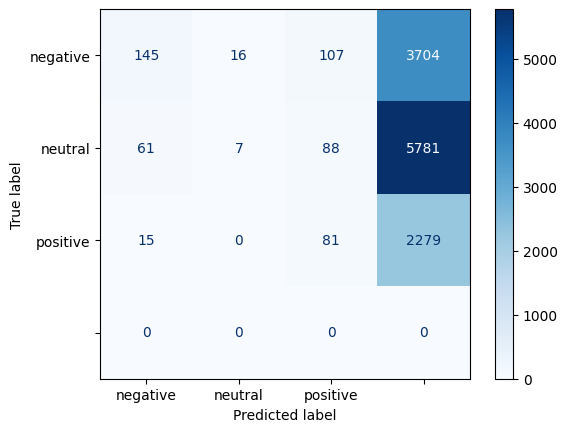

In [44]:
initial_f1_large_model = eval(model, dataset["test"], tokenizer)
print(f"Initial F1 large model: {initial_f1_large_model:.2f}")

### Обучим QLoRA

In [45]:
peft_config = LoraConfig(
    lora_alpha=16, # todo()
    lora_dropout=0.1, # todo()
    r=8, # todo()
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["k_proj", "v_proj"],
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)
model.train()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 2048)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=256, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=256, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lo

`SFTTrainer` supports conversational format:
```
{"messages": [{"role": "system", "content": "You are helpful"}, {"role": "user", "content": "What's the capital of France?"}, {"role": "assistant", "content": "..."}]}
{"messages": [{"role": "system", "content": "You are helpful"}, {"role": "user", "content": "Who wrote 'Romeo and Juliet'?"}, {"role": "assistant", "content": "..."}]}
{"messages": [{"role": "system", "content": "You are helpful"}, {"role": "user", "content": "How far is the Moon from Earth?"}, {"role": "assistant", "content": "..."}]}
```

In [46]:
def convert_instruction_format(example, system_prompt=SYSTEM_PROMPT):
    conversation = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"Text: {example['text']}"},
        {"role": "assistant", "content": example["str_label"]},
    ]
    return {"messages": conversation}


sft_dataset = dataset.copy()
for split, data in dataset.items():
    sft_dataset[split] = data.map(
        convert_instruction_format,
        remove_columns=["text", "label", "str_label", "prompt", "full_prompt", "input_ids", "full_input_ids"],
    )

for i in range(2):
    for k, v in sft_dataset["train"][i].items():
        print(f"{k}: {v}")
    print("=" * 10)

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

messages: [{'content': 'You are a tweet sentiment classifier. For each tweet input, analyze its sentiment and output exactly one word: "negative", "neutral", or "positive". Do not include any extra text.', 'role': 'system'}, {'content': 'Text: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"', 'role': 'user'}, {'content': 'positive', 'role': 'assistant'}]
messages: [{'content': 'You are a tweet sentiment classifier. For each tweet input, analyze its sentiment and output exactly one word: "negative", "neutral", or "positive". Do not include any extra text.', 'role': 'system'}, {'content': 'Text: "Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"', 'role': 'user'}, {'content': 'neutral', 'role': 'assistant'}]


In [47]:
training_arguments = TrainingArguments(
    # todo()
    num_train_epochs=1,
    per_device_train_batch_size=12,
    gradient_accumulation_steps=128,
    learning_rate=5e-4,
    lr_scheduler_type="linear",
    seed=42,
    logging_steps=1,
    report_to="none",
    label_names=[]
)

trainer = SFTTrainer(
    model=model,
    train_dataset=sft_dataset["train"],
    args=training_arguments,
    peft_config=peft_config,
    processing_class=tokenizer
)
trainer.train()

Converting train dataset to ChatML:   0%|          | 0/45615 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/45615 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/45615 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/45615 [00:00<?, ? examples/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
1,2.601900
2,2.511600
3,2.392200
4,2.285800
5,2.153600
6,2.032700
7,1.909300
8,1.804600
9,1.730300
10,1.640900


TrainOutput(global_step=29, training_loss=1.5493855435272743, metrics={'train_runtime': 936.2392, 'train_samples_per_second': 48.722, 'train_steps_per_second': 0.031, 'total_flos': 3.4906085530435584e+16, 'train_loss': 1.5493855435272743})

  0%|          | 0/123 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


QLoRA F1 large model: 0.19


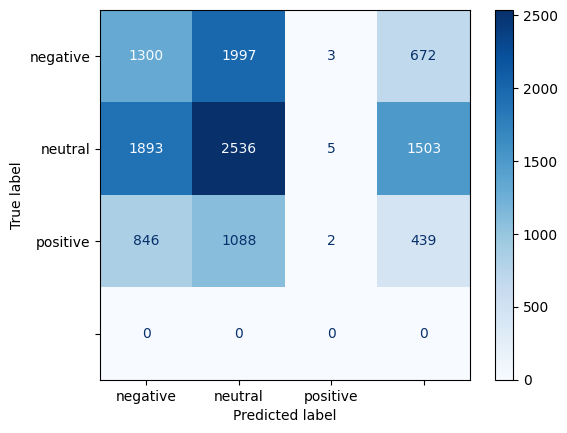

In [48]:
qlora_large_model = eval(model, dataset["test"], tokenizer)
print(f"QLoRA F1 large model: {qlora_large_model:.2f}")

In [49]:
# Загружаем все на хаб
model.push_to_hub(f"{REPO_NAME}-tinyllama-qlora-model", private=True)
tokenizer.push_to_hub(f"{REPO_NAME}-tinyllamma-qlora-tokenizer", private=True)

adapter_model.safetensors:   0%|          | 0.00/3.26M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/xinyuema/llm-course-hw3-tinyllamma-qlora-tokenizer/commit/7394160ae77a53a92e5801201d6777be2e07489b', commit_message='Upload tokenizer', commit_description='', oid='7394160ae77a53a92e5801201d6777be2e07489b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/xinyuema/llm-course-hw3-tinyllamma-qlora-tokenizer', endpoint='https://huggingface.co', repo_type='model', repo_id='xinyuema/llm-course-hw3-tinyllamma-qlora-tokenizer'), pr_revision=None, pr_num=None)